In [12]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F

In [15]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/Users/jshlomi/Desktop/Datasets/mnist/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/Users/jshlomi/Desktop/Datasets/mnist/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=500, shuffle=False)

In [16]:
for x,y in train_loader:
    break

In [17]:
x.shape

torch.Size([200, 1, 28, 28])

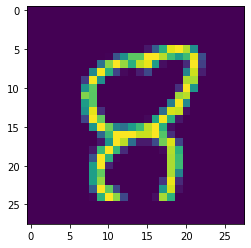

In [18]:
plt.imshow(x[0][0])

In [19]:
y[0]

tensor(8)

In [20]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Linear(28*28, 150)
        
        self.layer3 = nn.Linear(150,10)

        self.activation = nn.ReLU()
    
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation(out)
        out =   self.layer3(out) 
        
        return out

In [21]:
loss_func = nn.CrossEntropyLoss()

In [22]:
def batch_accuracy(net,x,y):
    batch_size,_,_,_ = x.shape
    output = net(x.view(batch_size,-1)).data.numpy()
    prediction = np.argmax(output,axis=1)
    correct =len(np.where(prediction==y.data.numpy())[0])
    return float(correct)/batch_size



In [197]:
dataset_accuracy(train_loader,net2)

0.11355

In [11]:
import torch.optim as optim

 

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR

In [26]:
nets = [ Net() , Net() , Net() ]
optimizers = [optim.SGD(net.parameters(), lr=lr) for net,lr in zip(nets,[0.009,0.01,0.011])]

net2 = Net()
optimizer2 = optim.SGD(net2.parameters(), lr=0.01)

In [27]:
scheduler = CyclicLR(optimizer2,base_lr=0.009,max_lr=0.011,step_size_up=50,step_size_down=50)

In [28]:
test_batch, test_batch_labels = iter(test_loader).next()

In [29]:
from tqdm.notebook import tqdm



def train_one_epoch(nn,optimizer,scheduler=None):
    learning_rates = []
    test_batch_accuracy = []
    losses = []
    
    
    
    for x,y in train_loader:
        learning_rates.append(optimizer.state_dict()['param_groups'][0]['lr'])
        test_batch_accuracy.append(batch_accuracy(nn,test_batch, test_batch_labels))
        
        nn.train()
        optimizer.zero_grad()
        batch_size,_,_,_ = x.shape
        output = nn(x.view(batch_size,-1))
        loss = loss_func(output,y)
        loss.backward()  
        optimizer.step()
        
        losses.append(loss.item())
        
    
    
        if scheduler is not None:
            scheduler.step()
    return learning_rates,test_batch_accuracy,losses

n_epochs = 2

training_stats = [np.zeros((0,3))]*4



for epoch in tqdm( range(n_epochs) ):
    for net_i, (net,optimizer) in enumerate( zip(nets,optimizers) ):
        lr, tb, ls =  train_one_epoch(net,optimizer)
        stats = np.column_stack( (lr, tb, ls) )
        training_stats[net_i] =  np.concatenate((training_stats[net_i],stats ))
    
    
    lr, tb, ls =  train_one_epoch(net2,optimizer2,scheduler)
    
    stats = np.column_stack( (lr, tb, ls) )
    training_stats[3] = np.concatenate((training_stats[3],stats ))

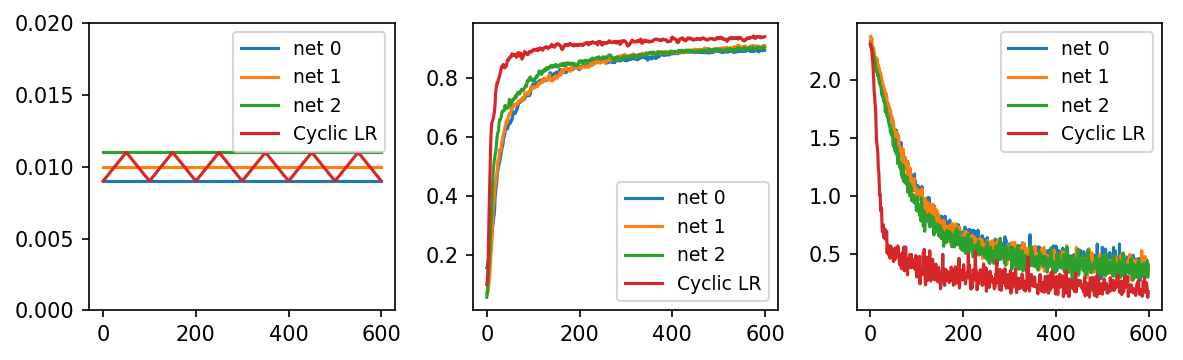

In [30]:
fig,ax = plt.subplots(1,3,figsize=(8,2.5),dpi=150)


for ax_i in range(3):
    for net_i in range(3):
        ax[ax_i].plot(training_stats[net_i][:,ax_i],label='net '+str(net_i))

    ax[ax_i].plot(training_stats[3][:,ax_i],label='Cyclic LR')




for i in range(3):
    ax[i].legend(fontsize=9)

ax[0].set_ylim(0,0.02)

plt.tight_layout()

plt.show()